In [37]:
%pip install mwparserfromhell
%pip install lxml
%pip install pyspark
%pip install nltk
%pip install numba
%pip install pandas
%pip install matplotlib
%pip install scipy
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated pa

Various imports

In [38]:
import csv
import re
import os.path
import shutil
import pandas as pd
import glob
import mwparserfromhell
import nltk
from nltk.corpus import stopwords
from lxml import etree
from pyspark.sql import SparkSession
from pyspark.sql.functions import lower, explode, split, regexp_replace, sum

import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.datasets import make_blobs

Static things

In [39]:
%%capture
nltk.download("stopwords")
header = ['Index', 'Text']
lista = []

#Testando una la alive progress bar
num_rows = 356900000
counter = 0
increment = 100000

[nltk_data] Downloading package stopwords to /home/fabbro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
print(stopwords)

<WordListCorpusReader in '/home/fabbro/nltk_data/corpora/stopwords'>


Dynamic things

----

In [41]:
%%capture
def removeNestedParentheses(s):
    lines = s.split('\n')
    print(len(lines))
    ret = []
    for line in lines:
        curr_line = ''
        skip = 0
        for i in line:
            if i == '[':
                skip += 1
            elif i == ']'and skip > 0:
                skip -= 1
            elif skip == 0:
                curr_line += i
        ret.append(curr_line+"\n")
    return '\n'.join(ret)

text = '''
I has a template! {{foo|bar|baz|eggs=spam}} See it <nowiki>or no<!-- revealed --></nowiki>[[File:wiki.png|thumb|Wikipedia logo]]? [[fox]] and [[dog|puppy]] New York also has [[public transport|public transportation]].


New York is a state in the Northeastern United States and is the 27th-most extensive, fourth-most populous, and seventh-most densely populated U.S. state. New York is bordered by New Jersey and Pennsylvania to the south and Connecticut, Massachusetts, and Vermont to the east. The state has a maritime border in the Atlantic Ocean with Rhode Island, east of Long Island, as well as an international border with the Canadian provinces of Quebec to the north and Ontario to the west and north. The state of New York, with an estimated 19.8 million residents in 2015, is often referred to as New York State to distinguish it from New York City, the state's most populous city and its economic hub.
With an estimated population of 8.55 million in 2015, New York City is the most populous city in the United States and the premier gateway for legal immigration to the United States. The New York City Metropolitan Area is one of the most populous urban agglomerations in the world. New York City is a global city, exerting a significant impact upon commerce, finance, media, art, fashion, research, technology, education, and entertainment, its fast pace defining the term New York minute. The home of the United Nations Headquarters, New York City is an important center for international diplomacy and has been described as the cultural and financial capital of the world, as well as the world's most economically powerful city. New York City makes up over 40% of the population of New York State. Two-thirds of the state's population lives in the New York City Metropolitan Area, and nearly 40% live on Long Island. Both the state and New York City were named for the 17th century Duke of York, future King James II of England. The next four most populous cities in the state are Buffalo, Rochester, Yonkers, and Syracuse, while the state capital is Albany.
The earliest Europeans in New York were French colonists and Jesuit missionaries who arrived southward from settlements at Montreal for trade and proselytizing. New York had been inhabited by tribes of Algonquian and Iroquoian-speaking Native Americans for several hundred years by the time Dutch settlers moved into the region in the early 17th century. In 1609, the region was first claimed by Henry Hudson for the Dutch, who built Fort Nassau in 1614 at the confluence of the Hudson and Mohawk rivers, where the present-day capital of Albany later developed. The Dutch soon also settled New Amsterdam and parts of the Hudson Valley, establishing the colony of New Netherland, a multicultural community from its earliest days and a center of trade and immigration. The British annexed the colony from the Dutch in 1664. The borders of the British colony, the Province of New York, were similar to those of the present-day state.
Many landmarks in New York are well known to both international and domestic visitors, with New York State hosting four of the world's ten most-visited tourist attractions in 2013: Times Square, Central Park, Niagara Falls (shared with Ontario), and Grand Central Terminal. New York is home to the Statue of Liberty, a symbol of the United States and its ideals of freedom, democracy, and opportunity. In the 21st century, New York has emerged as a global node of creativity and entrepreneurship, social tolerance, and environmental sustainability. New York's higher education network comprises approximately 200 colleges and universities, including Columbia University, Cornell University, New York University, and Rockefeller University, which have been ranked among the top 35 in the world.


== History ==


=== 16th century ===
In 1524, Giovanni da Verrazzano, an Italian explorer in the service of the French crown, explored the Atlantic coast of North America between the Carolinas and Newfoundland, including New York Harbor and Narragansett Bay. On April 17, 1524 Verrazanno entered New York Bay, by way of the Strait now called the Narrows into the northern bay which he named Santa Margherita, in honour of the King of France's sister. Verrazzano described it as "a vast coastline with a deep delta in which every kind of ship could pass" and he adds: "that it extends inland for a league and opens up to form a beautiful lake. This vast sheet of water swarmed with native boats". He landed on the tip of Manhattan and perhaps on the furthest point of Long Island. Verrazanno's stay in this place was interrupted by a storm which pushed him north towards Martha's Vineyard.
In 1540 French traders from New France built a chateau on Castle Island, within present-day Albany; due to flooding, it was abandoned the next year. In 1614, the Dutch under the command of Hendrick Corstiaensen, rebuilt the French chateau, which they called Fort Nassau. Fort Nassau was the first Dutch settlement in North America, and was located along the Hudson River, also within present-day Albany. The small fort served as a trading post and warehouse. Located on the Hudson River flood plain, the rudimentary "fort" was washed away by flooding in 1617, and abandoned for good after Fort Orange (New Netherland) was built nearby in 1623.


=== 17th century ===

Henry Hudson's 1609 voyage marked the beginning of European involvement with the area. Sailing for the Dutch East India Company and looking for a passage to Asia, he entered the Upper New York Bay on September 11 of that year. Word of his findings encouraged Dutch merchants to explore the coast in search for profitable fur trading with local Native American tribes.
During the 17th century, Dutch trading posts established for the trade of pelts from the Lenape, Iroquois, and other tribes were founded in the colony of New Netherland. The first of these trading posts were Fort Nassau (1614, near present-day Albany); Fort Orange (1624, on the Hudson River just south of the current city of Albany and created to replace Fort Nassau), developing into settlement Beverwijck (1647), and into what became Albany; Fort Amsterdam (1625, to develop into the town New Amsterdam which is present-day New York City); and Esopus, (1653, now Kingston). The success of the patroonship of Rensselaerswyck (1630), which surrounded Albany and lasted until the mid-19th century, was also a key factor in the early success of the colony. The English captured the colony during the Second Anglo-Dutch War and governed it as the Province of New York. The city of New York was recaptured by the Dutch in 1673 during the Third Anglo-Dutch War (1672–1674) and renamed New Orange. It was returned to the English under the terms of the Treaty of Westminster a year later.


== References ==


== Further reading ==

French, John Homer (1860). Historical and statistical gazetteer of New York State. Syracuse, New York: R. Pearsall Smith. OCLC 224691273. (Full text via Google Books.)
New York State Historical Association (1940). New York: A Guide to the Empire State. New York City: Oxford University Press. ISBN 978-1-60354-031-5. OCLC 504264143. (Full text via Google Books.)


== External links ==
New York at DMOZ
 Geographic data related to New York at OpenStreetMap'''



section_title_re = re.compile("^=+\s+.*\s+=+$")
content = ''
skip = False

for l in text.splitlines():
    line = l.strip()
    if "= references =" in line.lower():
        skip = True  # replace with break if this is the last section
        break
    if "= further reading =" in line.lower():
        skip = True  # replace with break if this is the last section
        continue
    if section_title_re.match(line):
        skip = False
        continue
    if skip:
        continue
    content+=line+'\n'
    
""" for x in content:
    if x != "":
        print(x.lower()+"\n")
 """
 
withoutPipeLinks = (re.sub(r"\[\[[^|\]]*\|([^|\]]*)]]", r"\1", content, flags=re.S))
withOutComments= re.sub('<!--.*?-->', '', withoutPipeLinks, flags=re.S)
cleaned= re.sub('<.*?>', '', withOutComments, flags=re.S)
testoPulito = removeNestedParentheses(cleaned)
wikicode = mwparserfromhell.parse(testoPulito)
templates = wikicode.filter_templates()
text = " ".join([testo for testo in testoPulito.split() if testo not in templates])
print(text)

----

Pulisco per bene il file tenendo soltanto le parole, pulendole da tutti i tag (parentesi quadrate, ad esempio) e da tutti i simboli di punteggiatura.
Inoltre vado anche a cancellare i paragrafi ed i loro titoli. Da qui si creerá un metodo che verrá utilizzato 

In [42]:
def removeNestedParentheses(s):
    lines = s.split('\n')
    ret = []
    for line in lines:
        curr_line = ''
        skip = 0
        for i in line:
            if i == '[' or i == '{' :
                skip += 1
            elif (i == ']' or i == '}' ) and skip > 0:
                skip -= 1
            elif skip == 0:
                curr_line += i
        ret.append(curr_line+"\n")
    return '\n'.join(ret)

def cleanUp(text):
    section_title_re = re.compile("^=+\s+.*\s+=+$")
    content = ''
    skip = False

    for l in text.splitlines():
        line = l.strip()
        if "= references =" in line.lower():
            skip = True  # replace with break if this is the last section
            break
        if "= further reading =" in line.lower():
            skip = True  # replace with break if this is the last section
            continue
        if section_title_re.match(line):
            skip = False
            continue
        if skip:
            continue
        content+=line+'\n'
    
    withoutPipeLinks = (re.sub(r"\[\[[^|\]]*\|([^|\]]*)]]", r"\1", content, flags=re.S))
    withOutComments= re.sub('<!--.*?-->', '', withoutPipeLinks, flags=re.S)
    cleaned= re.sub('<.*?>', '', withOutComments, flags=re.S)
    testoPulito = removeNestedParentheses(cleaned)
    wikicode = mwparserfromhell.parse(testoPulito)
    templates = wikicode.filter_templates()
    text = " ".join([testo for testo in testoPulito.split() if testo not in templates])
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    if text == "":
        return "NullTextFound"
    else:
        return text

Vado a creare un file csv con i titoli della pagina e le parole in essa contenute. Vado inoltre ad eliminare tutte le stop words.

In [43]:
stop_words = set(stopwords.words("english"))
def remove_w(text):
    return ' '.join(w for w in text.split() if w not in stop_words)

In [45]:
fileWords = open("fileWords.csv", "w+")
fileTitles = open("fileTitles.csv", "w+")

wordsWriter = csv.writer(fileWords)
titlesWriter = csv.writer(fileTitles)

titlesWriter.writerow(["index", "title"])
wordsWriter.writerow(["index", "text"])
section_title_re = re.compile("^=+\s+.*\s+=+$")
skip = False

i = 0
j = 0
totalCount = 0
titles_list = []
words_list = []
file_xml= ''
if os.path.isfile("/home/fabbro/Documents/Cartella/fileWiki.xml"):
    file_xml = "/home/fabbro/Documents/Cartella/fileWiki.xml"
elif os.path.isfile("/home/fabbro/Documents/Big-Data/file.xml"):
    file_xml = "/home/fabbro/Documents/Big-Data/file.xml"
else:
    print("File non trovato")
tupla_titolo = ()
tupla_testo = ()
for event, elem in etree.iterparse(file_xml):
    text = ""
    title=""
    
    if('title' in str(elem.tag)):
        if(elem.text is not None):
            i = i+1
            title = elem.text.lower()
            titlesWriter.writerow([i, title])

    if('text' in str(elem.tag)):
        if(elem.text is not None):
            j = j+1
            text = remove_w(cleanUp(elem.text.lower()))
            wordsWriter.writerow([j, text])

    if j == 1000000 and i == 1000000:
        break
    elem.clear()
    totalCount += 1
    if totalCount > 1 and (totalCount % 1000) == 0:
            percents = (totalCount/1000000)*100
            print(f"Percents: {percents:.2f}%", end="\r")
            if percents == 100:
                break

print("-------------------------------------------DONE------------------------------------------------------")

-------------------------------------------DONE------------------------------------------------------


### Inizio ad utilizzare PySpark utilizzando SparkSession

In [46]:
spark = SparkSession.builder.appName("mySparkApp").config("spark.driver.memory", "4g").config("spark.driver.maxResultSize", "12g").getOrCreate()

<b> Carico i due file come DF </b> <i> poi unendoli in un unico DF tenendo come chiave d'unione l'index</i>. Vado quindi a pulire quel che é stato generato (una cartella) mantenendo solo quel che ci serve a noi: il file csv con i dati.
\
<i> Attenzione: se esiste ancora una cartella di nome "merged_file", essa viene cancellata per evitare conflitti o errori. </i>
\
\
Alla fine vado anche a cancellare fileWords.csv e fileTitles.csv in quanto non ci serviraranno piú.

In [47]:
if os.path.isdir("merged_file"):
    shutil.rmtree("merged_file")

titles_df = spark.read.csv("fileTitles.csv", header=True, inferSchema=True)
text_df = spark.read.csv("fileWords.csv", header=True, inferSchema=True)

merged_df = titles_df.join(text_df, "index")

merged_df.coalesce(1).write.csv("merged_file", header=True)

for filename in os.listdir("merged_file"):
    if filename.endswith(".csv"):
        os.rename(os.path.join("merged_file", filename), os.path.join("", "merged.csv"))
        shutil.rmtree("merged_file")
os.remove("fileWords.csv")
os.remove("fileTitles.csv")

Ora bisogna mappare le parole (contando quante ce ne sono) presenti in ogni cella del file CSV. Tiene conto quindi del titolo, la parola che é presente in quella pagina e quante volte viene utilizzata in quel titolo.
\
Eliminiamo merged.csv.

In [48]:
df = spark.read.format("csv").option("header", "true").load("merged.csv")
df = df.select("title", lower("text").alias("text"))

words_df = df.select("title", explode(split(regexp_replace("text", r'\W+', ' '), ' ')).alias("word"))

word_counts = words_df.groupBy("title", "word").count().orderBy("count", ascending=False)
word_counts.write.csv("countedWordsDir", mode="overwrite", header=True)

os.remove("merged.csv")

23/04/07 17:50:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/07 17:50:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/07 17:50:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/07 17:50:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/07 17:50:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/07 17:50:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/07 17:50:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/07 17:50:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/07 17:50:02 WARN RowBasedKeyValueBatch: Calling spill() on

Vado ad unire tutti i files CSV creati precedentemente.

In [49]:
# ottieni la lista di tutti i file CSV nella cartella
csv_files = glob.glob("countedWordsDir/*.csv")

# crea una lista di dataframe leggendo i file CSV
dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

# unisci i dataframe in uno solo
merged_df = pd.concat(dfs)

# scrivi il dataframe unificato in un file CSV
merged_df.to_csv("countedWords.csv", index=False)

shutil.rmtree("countedWordsDir")

<b>L’output deve contenere, per ogni parola, la lista di pagine di wikipedia
che contengono quella parola</b>

Quante volte sono state utilizzate le singole parole? Salviamo il risultato, poi, nel file "countedWordsFinalOutput.csv", unendo i file precedentemente generati separatamente.

In [50]:
df = spark.read.format("csv").option("header", "true").load("countedWords.csv")

# raggruppa le righe in base alla colonna "word" e somma la colonna "count"
sum_df = df.groupBy("word").agg(sum("count").alias("total_count"))
sum_df = sum_df.withColumn("total_count", sum_df["total_count"].cast("int"))

sum_df.write.mode("overwrite").csv("paroleContate", header=True)

#Unione dei file
csv_files = glob.glob("paroleContate/*.csv")

dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

merged_df = pd.concat(dfs)
merged_df.to_csv("countedWordsFinalOutput.csv", index=False)

shutil.rmtree("paroleContate")

---

Elimino la colonna che ci é inutile (la colonna count) salvando il risultato su un ultimo file finale, da analizzare. Elimino poi il file countedWords.csv che non ci servirá a nulla.

In [51]:
df = pd.read_csv('countedWords.csv')
df.drop('count', axis=1, inplace=True)
df.to_csv('finalFileToAnalyze.csv', index=False)
os.remove('countedWords.csv')

Leggiamo tutte le parole presenti nella colonna "word" del file CSV. Utilizziamo un set in quanto non vogliamo che ci siano parole ripetute. Poi lo trasformiamo in una lista per renderlo indicizzabile e la trascriviamo in un file csv in modo da non dover eseguire ogni volta questa cella.

In [52]:
df = pd.read_csv('finalFileToAnalyze.csv')
word_list = []
for row in df['word']:
    words = re.findall(r'\w+', str(row).lower())
    word_list.extend(words)

word_list = list(set(word_list))

Ora controllo quali parole sono presenti nel file finale da controllare. Se le parole sono presenti, aggiungo il titolo ad una lista. Si creerá infine una riga in un file CSV con la parola e la lista di titoli.
\
Eliminiamo <b>finalFileToAnalyze.csv</b> in quanto inutile. Dovremmo utilizzare risults.csv per le analisi.

In [53]:
# Apri il file CSV contenente i titoli e le parole
with open('finalFileToAnalyze.csv', newline='') as csv_file:
    reader = csv.DictReader(csv_file)

    # Crea un dizionario per mantenere le associazioni tra parole e titoli
    word_title_dict = {}

    # Itera su ogni riga del file CSV
    for row in reader:
        # Estrai il titolo e la parola dalla riga
        title = row['title']
        word = row['word']

        # Se la parola non è ancora presente nel dizionario, aggiungila
        if word not in word_title_dict:
            word_title_dict[word] = []

        # Aggiungi il titolo alla lista di titoli associata alla parola
        word_title_dict[word].append(title)

# Apri un nuovo file CSV per scrivere i risultati
with open('results.csv', mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)

    # Scrivi l'intestazione delle colonne
    writer.writerow(['word', 'titles'])

    # Itera su ogni parola del tuo elenco di parole
    for word in word_list:
        # Se la parola è presente nel dizionario, estrai i titoli associati
        if word in word_title_dict:
            titles = word_title_dict[word]
        else:
            titles = []

        # Scrivi una riga nel file CSV contenente la parola e i titoli associati
        writer.writerow([word, titles])
os.remove("finalFileToAnalyze.csv")


---
Iniziamo con i grafici

In [54]:
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.datasets import make_blobs

In [61]:
temp_df = pd.read_csv('countedWordsFinalOutput.csv', header=0)
ordered = temp_df.sort_values(by=['total_count'], ascending=False)
print(ordered.head(10).describe())


         total_count
count      10.000000
mean   196386.100000
std     53871.752552
min    134314.000000
25%    164343.500000
50%    181239.000000
75%    225908.000000
max    307475.000000


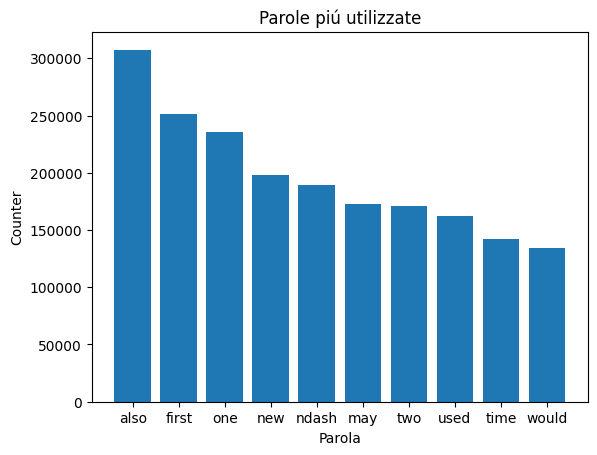

In [64]:
data = pd.read_csv('countedWordsFinalOutput.csv')
data = data.sort_values(by=['total_count'], ascending=False)
data = data.head(10)
x = data['word']
y = data['total_count']

plt.bar(x, y)
plt.title('Parole piú utilizzate')
plt.xlabel('Parola')
plt.ylabel('Counter')
plt.show()
